In [1]:
!pip install torch torchvision pillow matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device)

content_img = load_image("photo.jpg")
style_img = load_image("photo2.jpg")


In [3]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 92.2MB/s]


In [4]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

content_layers = ['21']
style_layers = ['0', '5', '10', '19', '28']


In [9]:
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


vgg_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
}

content_features = get_features(content_img, vgg, vgg_layers)
style_features = get_features(style_img, vgg, vgg_layers)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

generated = content_img.clone().requires_grad_(True)

optimizer = optim.Adam([generated], lr=0.003)

content_weight = 1e4
style_weight = 1e2

for step in range(300):
    gen_features = get_features(generated, vgg, vgg_layers)

    content_loss = torch.mean(
        (gen_features['conv4_2'] - content_features['conv4_2']) ** 2
    )

    style_loss = 0
    for layer in style_grams:
        gen_gram = gram_matrix(gen_features[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((gen_gram - style_gram) ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item():.4f}")


Step 0, Total Loss: 30669625344.0000
Step 50, Total Loss: 4141459712.0000
Step 100, Total Loss: 2409188352.0000
Step 150, Total Loss: 1631268992.0000
Step 200, Total Loss: 1125960576.0000
Step 250, Total Loss: 773962432.0000


Stylized image saved as 'stylized_output.png'


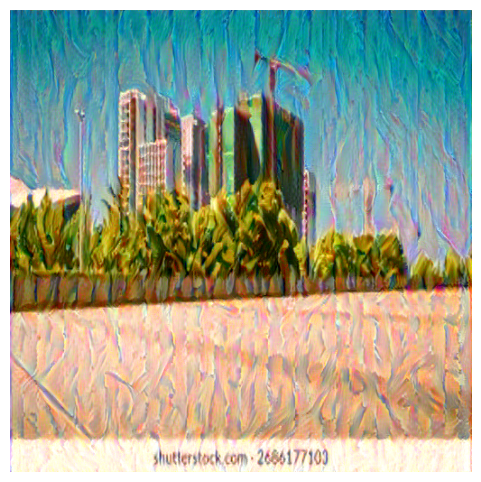

In [12]:
output = generated.detach().cpu().squeeze()
output= torch.clamp(output, 0, 1)

plt.figure(figsize=(6,6))
plt.imshow(output.permute(1,2,0))
plt.axis("off")

plt.imsave("stylized_output.png", output.permute(1,2,0).numpy())
print("Stylized image saved as 'stylized_output.png'")
